# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.408017
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.570945 analytic: 0.570945, relative error: 1.115094e-07
numerical: -1.617389 analytic: -1.617389, relative error: 7.358177e-10
numerical: -2.535233 analytic: -2.535233, relative error: 1.014519e-08
numerical: -1.742513 analytic: -1.742513, relative error: 7.894206e-10
numerical: 2.575943 analytic: 2.575943, relative error: 2.237181e-08
numerical: 1.560668 analytic: 1.560668, relative error: 2.110130e-08
numerical: -1.992912 analytic: -1.992912, relative error: 1.489131e-08
numerical: 0.184325 analytic: 0.184325, relative error: 8.159676e-08
numerical: 2.360323 analytic: 2.360322, relative error: 2.533928e-08
numerical: -4.511496 analytic: -4.511496, relative error: 1.030911e-08
numerical: -0.733864 analytic: -0.733864, relative error: 2.068902e-08
numerical: 1.081258 analytic: 1.081258, relative error: 5.425535e-08
numerical: 0.994804 analytic: 0.994804, relative error: 3.574164e-08
numerical: -2.522186 analytic: -2.522186, relative error: 3.771767e-09
numerical: 1.702662 

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.408017e+00 computed in 0.093786s
vectorized loss: 2.408017e+00 computed in 0.328216s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.random.uniform(low = 0.2e-7, high = 5e-7, size = (20, ))
regularization_strengths = np.random.uniform(low = 1e4, high = 5e4, size = (20, ))

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rates[i], regularization_strengths[j], 1500, 200, True)
        train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == train_pred)
        val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == val_pred)
        results[(learning_rates[i], regularization_strengths[j])] = (train_acc, val_acc)
        if(val_acc > best_val):
            best_val = val_acc
            best_softmax = softmax
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 465.141624
iteration 100 / 1500: loss 71.764337
iteration 200 / 1500: loss 12.631763
iteration 300 / 1500: loss 3.638263
iteration 400 / 1500: loss 2.290522
iteration 500 / 1500: loss 2.059245
iteration 600 / 1500: loss 2.056500
iteration 700 / 1500: loss 2.035948
iteration 800 / 1500: loss 2.021227
iteration 900 / 1500: loss 2.074416
iteration 1000 / 1500: loss 2.021201
iteration 1100 / 1500: loss 2.042824
iteration 1200 / 1500: loss 2.048867
iteration 1300 / 1500: loss 2.072608
iteration 1400 / 1500: loss 2.074004
iteration 0 / 1500: loss 413.867317
iteration 100 / 1500: loss 76.897053
iteration 200 / 1500: loss 15.601142
iteration 300 / 1500: loss 4.523832
iteration 400 / 1500: loss 2.467960
iteration 500 / 1500: loss 2.103795
iteration 600 / 1500: loss 2.054970
iteration 700 / 1500: loss 2.045260
iteration 800 / 1500: loss 2.050544
iteration 900 / 1500: loss 1.967916
iteration 1000 / 1500: loss 2.005155
iteration 1100 / 1500: loss 2.010484
iteration 1200 / 

iteration 0 / 1500: loss 386.538409
iteration 100 / 1500: loss 80.194411
iteration 200 / 1500: loss 17.904511
iteration 300 / 1500: loss 5.344200
iteration 400 / 1500: loss 2.657766
iteration 500 / 1500: loss 2.135625
iteration 600 / 1500: loss 2.061461
iteration 700 / 1500: loss 2.040541
iteration 800 / 1500: loss 2.042464
iteration 900 / 1500: loss 1.963175
iteration 1000 / 1500: loss 2.029368
iteration 1100 / 1500: loss 2.036958
iteration 1200 / 1500: loss 2.046577
iteration 1300 / 1500: loss 1.996702
iteration 1400 / 1500: loss 2.083128
iteration 0 / 1500: loss 1252.038466
iteration 100 / 1500: loss 9.021513
iteration 200 / 1500: loss 2.140554
iteration 300 / 1500: loss 2.169614
iteration 400 / 1500: loss 2.107457
iteration 500 / 1500: loss 2.124314
iteration 600 / 1500: loss 2.141996
iteration 700 / 1500: loss 2.123387
iteration 800 / 1500: loss 2.074613
iteration 900 / 1500: loss 2.145805
iteration 1000 / 1500: loss 2.090773
iteration 1100 / 1500: loss 2.077120
iteration 1200 / 1

iteration 1100 / 1500: loss 44.796487
iteration 1200 / 1500: loss 36.354498
iteration 1300 / 1500: loss 29.655584
iteration 1400 / 1500: loss 24.249464
iteration 0 / 1500: loss 328.150049
iteration 100 / 1500: loss 281.583609
iteration 200 / 1500: loss 242.504576
iteration 300 / 1500: loss 208.786560
iteration 400 / 1500: loss 180.073477
iteration 500 / 1500: loss 154.910228
iteration 600 / 1500: loss 133.469389
iteration 700 / 1500: loss 115.256714
iteration 800 / 1500: loss 99.314385
iteration 900 / 1500: loss 85.823883
iteration 1000 / 1500: loss 74.087375
iteration 1100 / 1500: loss 64.109755
iteration 1200 / 1500: loss 55.308014
iteration 1300 / 1500: loss 47.857940
iteration 1400 / 1500: loss 41.512305
iteration 0 / 1500: loss 364.917134
iteration 100 / 1500: loss 309.185646
iteration 200 / 1500: loss 262.135751
iteration 300 / 1500: loss 222.451481
iteration 400 / 1500: loss 188.802951
iteration 500 / 1500: loss 160.599791
iteration 600 / 1500: loss 136.426179
iteration 700 / 15

iteration 400 / 1500: loss 197.550995
iteration 500 / 1500: loss 119.402378
iteration 600 / 1500: loss 72.538809
iteration 700 / 1500: loss 44.338224
iteration 800 / 1500: loss 27.448390
iteration 900 / 1500: loss 17.325965
iteration 1000 / 1500: loss 11.270908
iteration 1100 / 1500: loss 7.566033
iteration 1200 / 1500: loss 5.421515
iteration 1300 / 1500: loss 4.090965
iteration 1400 / 1500: loss 3.310174
iteration 0 / 1500: loss 823.596987
iteration 100 / 1500: loss 625.851513
iteration 200 / 1500: loss 475.498422
iteration 300 / 1500: loss 361.331254
iteration 400 / 1500: loss 275.036707
iteration 500 / 1500: loss 209.473586
iteration 600 / 1500: loss 159.753395
iteration 700 / 1500: loss 121.790926
iteration 800 / 1500: loss 92.985679
iteration 900 / 1500: loss 71.196878
iteration 1000 / 1500: loss 54.516976
iteration 1100 / 1500: loss 41.886513
iteration 1200 / 1500: loss 32.385171
iteration 1300 / 1500: loss 25.093805
iteration 1400 / 1500: loss 19.554321
iteration 0 / 1500: loss

iteration 1200 / 1500: loss 82.206401
iteration 1300 / 1500: loss 72.416933
iteration 1400 / 1500: loss 63.751812
iteration 0 / 1500: loss 1276.943487
iteration 100 / 1500: loss 829.691296
iteration 200 / 1500: loss 539.360399
iteration 300 / 1500: loss 351.072029
iteration 400 / 1500: loss 228.754151
iteration 500 / 1500: loss 149.378256
iteration 600 / 1500: loss 97.615947
iteration 700 / 1500: loss 64.219220
iteration 800 / 1500: loss 42.401956
iteration 900 / 1500: loss 28.322956
iteration 1000 / 1500: loss 19.141009
iteration 1100 / 1500: loss 13.195598
iteration 1200 / 1500: loss 9.322232
iteration 1300 / 1500: loss 6.810778
iteration 1400 / 1500: loss 5.151649
iteration 0 / 1500: loss 459.886836
iteration 100 / 1500: loss 307.887136
iteration 200 / 1500: loss 207.041721
iteration 300 / 1500: loss 139.195435
iteration 400 / 1500: loss 93.840702
iteration 500 / 1500: loss 63.629594
iteration 600 / 1500: loss 43.326212
iteration 700 / 1500: loss 29.673342
iteration 800 / 1500: loss

iteration 800 / 1500: loss 27.040730
iteration 900 / 1500: loss 19.700838
iteration 1000 / 1500: loss 14.505218
iteration 1100 / 1500: loss 10.895844
iteration 1200 / 1500: loss 8.347107
iteration 1300 / 1500: loss 6.488674
iteration 1400 / 1500: loss 5.137226
iteration 0 / 1500: loss 1083.137127
iteration 100 / 1500: loss 418.664669
iteration 200 / 1500: loss 162.734116
iteration 300 / 1500: loss 64.045548
iteration 400 / 1500: loss 25.939529
iteration 500 / 1500: loss 11.262644
iteration 600 / 1500: loss 5.656433
iteration 700 / 1500: loss 3.511372
iteration 800 / 1500: loss 2.655100
iteration 900 / 1500: loss 2.322970
iteration 1000 / 1500: loss 2.210775
iteration 1100 / 1500: loss 2.123310
iteration 1200 / 1500: loss 2.135362
iteration 1300 / 1500: loss 2.101918
iteration 1400 / 1500: loss 2.098697
iteration 0 / 1500: loss 384.704082
iteration 100 / 1500: loss 274.295439
iteration 200 / 1500: loss 195.759427
iteration 300 / 1500: loss 140.484851
iteration 400 / 1500: loss 100.84664

iteration 700 / 1500: loss 2.143390
iteration 800 / 1500: loss 2.155587
iteration 900 / 1500: loss 2.105802
iteration 1000 / 1500: loss 2.198149
iteration 1100 / 1500: loss 2.125957
iteration 1200 / 1500: loss 2.092602
iteration 1300 / 1500: loss 2.153229
iteration 1400 / 1500: loss 2.143311
iteration 0 / 1500: loss 471.346198
iteration 100 / 1500: loss 25.743547
iteration 200 / 1500: loss 3.305027
iteration 300 / 1500: loss 2.105051
iteration 400 / 1500: loss 1.990944
iteration 500 / 1500: loss 2.023193
iteration 600 / 1500: loss 1.943573
iteration 700 / 1500: loss 2.023658
iteration 800 / 1500: loss 2.037428
iteration 900 / 1500: loss 2.026086
iteration 1000 / 1500: loss 1.974479
iteration 1100 / 1500: loss 2.082682
iteration 1200 / 1500: loss 2.062853
iteration 1300 / 1500: loss 2.000115
iteration 1400 / 1500: loss 2.015029
iteration 0 / 1500: loss 328.537217
iteration 100 / 1500: loss 43.578112
iteration 200 / 1500: loss 7.376676
iteration 300 / 1500: loss 2.782266
iteration 400 / 

iteration 700 / 1500: loss 2.140336
iteration 800 / 1500: loss 2.159854
iteration 900 / 1500: loss 2.161145
iteration 1000 / 1500: loss 2.162881
iteration 1100 / 1500: loss 2.084754
iteration 1200 / 1500: loss 2.134308
iteration 1300 / 1500: loss 2.149704
iteration 1400 / 1500: loss 2.168620
iteration 0 / 1500: loss 1491.620631
iteration 100 / 1500: loss 28.849983
iteration 200 / 1500: loss 2.649782
iteration 300 / 1500: loss 2.144349
iteration 400 / 1500: loss 2.125499
iteration 500 / 1500: loss 2.130553
iteration 600 / 1500: loss 2.160416
iteration 700 / 1500: loss 2.113277
iteration 800 / 1500: loss 2.127344
iteration 900 / 1500: loss 2.126075
iteration 1000 / 1500: loss 2.147172
iteration 1100 / 1500: loss 2.158216
iteration 1200 / 1500: loss 2.101125
iteration 1300 / 1500: loss 2.210756
iteration 1400 / 1500: loss 2.139317
iteration 0 / 1500: loss 817.899592
iteration 100 / 1500: loss 96.581557
iteration 200 / 1500: loss 13.038004
iteration 300 / 1500: loss 3.339408
iteration 400 

iteration 700 / 1500: loss 2.325464
iteration 800 / 1500: loss 2.133478
iteration 900 / 1500: loss 2.071034
iteration 1000 / 1500: loss 2.012263
iteration 1100 / 1500: loss 2.023958
iteration 1200 / 1500: loss 1.989983
iteration 1300 / 1500: loss 2.087782
iteration 1400 / 1500: loss 1.937252
iteration 0 / 1500: loss 1279.678270
iteration 100 / 1500: loss 45.105973
iteration 200 / 1500: loss 3.564248
iteration 300 / 1500: loss 2.155382
iteration 400 / 1500: loss 2.141421
iteration 500 / 1500: loss 2.156353
iteration 600 / 1500: loss 2.127325
iteration 700 / 1500: loss 2.077129
iteration 800 / 1500: loss 2.132773
iteration 900 / 1500: loss 2.165169
iteration 1000 / 1500: loss 2.139610
iteration 1100 / 1500: loss 2.093238
iteration 1200 / 1500: loss 2.145720
iteration 1300 / 1500: loss 2.163099
iteration 1400 / 1500: loss 2.177082
iteration 0 / 1500: loss 464.314553
iteration 100 / 1500: loss 53.779940
iteration 200 / 1500: loss 7.901611
iteration 300 / 1500: loss 2.702032
iteration 400 /

iteration 700 / 1500: loss 2.061249
iteration 800 / 1500: loss 2.050243
iteration 900 / 1500: loss 2.010694
iteration 1000 / 1500: loss 2.007229
iteration 1100 / 1500: loss 1.983037
iteration 1200 / 1500: loss 2.041401
iteration 1300 / 1500: loss 2.052842
iteration 1400 / 1500: loss 2.058935
iteration 0 / 1500: loss 1077.201258
iteration 100 / 1500: loss 7.886822
iteration 200 / 1500: loss 2.166288
iteration 300 / 1500: loss 2.078379
iteration 400 / 1500: loss 2.040595
iteration 500 / 1500: loss 2.104125
iteration 600 / 1500: loss 2.141316
iteration 700 / 1500: loss 2.099673
iteration 800 / 1500: loss 2.050359
iteration 900 / 1500: loss 2.159205
iteration 1000 / 1500: loss 2.078322
iteration 1100 / 1500: loss 2.173327
iteration 1200 / 1500: loss 2.072011
iteration 1300 / 1500: loss 2.101738
iteration 1400 / 1500: loss 2.123763
iteration 0 / 1500: loss 385.016713
iteration 100 / 1500: loss 62.466174
iteration 200 / 1500: loss 11.663674
iteration 300 / 1500: loss 3.568399
iteration 400 /

iteration 600 / 1500: loss 2.469053
iteration 700 / 1500: loss 2.217037
iteration 800 / 1500: loss 2.163509
iteration 900 / 1500: loss 2.108792
iteration 1000 / 1500: loss 2.124409
iteration 1100 / 1500: loss 2.119258
iteration 1200 / 1500: loss 2.128372
iteration 1300 / 1500: loss 2.131754
iteration 1400 / 1500: loss 2.135079
iteration 0 / 1500: loss 470.663227
iteration 100 / 1500: loss 299.536576
iteration 200 / 1500: loss 191.097903
iteration 300 / 1500: loss 122.405194
iteration 400 / 1500: loss 78.827096
iteration 500 / 1500: loss 50.953348
iteration 600 / 1500: loss 33.089452
iteration 700 / 1500: loss 21.877747
iteration 800 / 1500: loss 14.707193
iteration 900 / 1500: loss 10.067150
iteration 1000 / 1500: loss 7.170521
iteration 1100 / 1500: loss 5.354899
iteration 1200 / 1500: loss 4.128990
iteration 1300 / 1500: loss 3.398532
iteration 1400 / 1500: loss 2.855702
iteration 0 / 1500: loss 327.226003
iteration 100 / 1500: loss 238.723572
iteration 200 / 1500: loss 175.465707
it

iteration 400 / 1500: loss 2.123129
iteration 500 / 1500: loss 2.136358
iteration 600 / 1500: loss 2.115884
iteration 700 / 1500: loss 2.153752
iteration 800 / 1500: loss 2.152174
iteration 900 / 1500: loss 2.138752
iteration 1000 / 1500: loss 2.178200
iteration 1100 / 1500: loss 2.146350
iteration 1200 / 1500: loss 2.151964
iteration 1300 / 1500: loss 2.142930
iteration 1400 / 1500: loss 2.192010
iteration 0 / 1500: loss 1519.030275
iteration 100 / 1500: loss 10.095753
iteration 200 / 1500: loss 2.206194
iteration 300 / 1500: loss 2.164437
iteration 400 / 1500: loss 2.158309
iteration 500 / 1500: loss 2.098695
iteration 600 / 1500: loss 2.114842
iteration 700 / 1500: loss 2.155334
iteration 800 / 1500: loss 2.162662
iteration 900 / 1500: loss 2.110659
iteration 1000 / 1500: loss 2.151008
iteration 1100 / 1500: loss 2.166587
iteration 1200 / 1500: loss 2.100341
iteration 1300 / 1500: loss 2.156782
iteration 1400 / 1500: loss 2.173942
iteration 0 / 1500: loss 802.980722
iteration 100 / 

iteration 400 / 1500: loss 3.882865
iteration 500 / 1500: loss 2.531648
iteration 600 / 1500: loss 2.158657
iteration 700 / 1500: loss 2.105290
iteration 800 / 1500: loss 1.993230
iteration 900 / 1500: loss 2.022560
iteration 1000 / 1500: loss 2.008689
iteration 1100 / 1500: loss 2.046501
iteration 1200 / 1500: loss 1.924894
iteration 1300 / 1500: loss 1.983538
iteration 1400 / 1500: loss 2.061286
iteration 0 / 1500: loss 1285.161846
iteration 100 / 1500: loss 17.363435
iteration 200 / 1500: loss 2.349429
iteration 300 / 1500: loss 2.115615
iteration 400 / 1500: loss 2.134763
iteration 500 / 1500: loss 2.100461
iteration 600 / 1500: loss 2.167945
iteration 700 / 1500: loss 2.121397
iteration 800 / 1500: loss 2.089324
iteration 900 / 1500: loss 2.147472
iteration 1000 / 1500: loss 2.130631
iteration 1100 / 1500: loss 2.137421
iteration 1200 / 1500: loss 2.157707
iteration 1300 / 1500: loss 2.065068
iteration 1400 / 1500: loss 2.097744
iteration 0 / 1500: loss 457.964889
iteration 100 / 

iteration 300 / 1500: loss 55.610435
iteration 400 / 1500: loss 29.691276
iteration 500 / 1500: loss 16.238798
iteration 600 / 1500: loss 9.318768
iteration 700 / 1500: loss 5.820675
iteration 800 / 1500: loss 4.011819
iteration 900 / 1500: loss 2.974545
iteration 1000 / 1500: loss 2.535557
iteration 1100 / 1500: loss 2.255354
iteration 1200 / 1500: loss 2.149930
iteration 1300 / 1500: loss 2.131107
iteration 1400 / 1500: loss 2.110166
iteration 0 / 1500: loss 1077.113473
iteration 100 / 1500: loss 174.148754
iteration 200 / 1500: loss 29.684318
iteration 300 / 1500: loss 6.567152
iteration 400 / 1500: loss 2.803287
iteration 500 / 1500: loss 2.170621
iteration 600 / 1500: loss 2.149420
iteration 700 / 1500: loss 2.131309
iteration 800 / 1500: loss 2.112397
iteration 900 / 1500: loss 2.084010
iteration 1000 / 1500: loss 2.059834
iteration 1100 / 1500: loss 2.130008
iteration 1200 / 1500: loss 2.135148
iteration 1300 / 1500: loss 2.100451
iteration 1400 / 1500: loss 2.143594
iteration 0

iteration 0 / 1500: loss 1453.314638
iteration 100 / 1500: loss 534.453102
iteration 200 / 1500: loss 197.583689
iteration 300 / 1500: loss 73.813704
iteration 400 / 1500: loss 28.518786
iteration 500 / 1500: loss 11.880446
iteration 600 / 1500: loss 5.681632
iteration 700 / 1500: loss 3.399950
iteration 800 / 1500: loss 2.660565
iteration 900 / 1500: loss 2.310251
iteration 1000 / 1500: loss 2.193906
iteration 1100 / 1500: loss 2.192822
iteration 1200 / 1500: loss 2.183607
iteration 1300 / 1500: loss 2.153816
iteration 1400 / 1500: loss 2.110536
iteration 0 / 1500: loss 471.867396
iteration 100 / 1500: loss 341.436061
iteration 200 / 1500: loss 247.667399
iteration 300 / 1500: loss 179.614016
iteration 400 / 1500: loss 130.569062
iteration 500 / 1500: loss 95.184561
iteration 600 / 1500: loss 69.215116
iteration 700 / 1500: loss 50.750061
iteration 800 / 1500: loss 37.300025
iteration 900 / 1500: loss 27.540915
iteration 1000 / 1500: loss 20.566114
iteration 1100 / 1500: loss 15.47155

iteration 1100 / 1500: loss 2.030763
iteration 1200 / 1500: loss 2.051618
iteration 1300 / 1500: loss 2.053750
iteration 1400 / 1500: loss 2.047491
iteration 0 / 1500: loss 1537.428783
iteration 100 / 1500: loss 75.629491
iteration 200 / 1500: loss 5.637297
iteration 300 / 1500: loss 2.316329
iteration 400 / 1500: loss 2.129265
iteration 500 / 1500: loss 2.108470
iteration 600 / 1500: loss 2.195013
iteration 700 / 1500: loss 2.092492
iteration 800 / 1500: loss 2.135160
iteration 900 / 1500: loss 2.191181
iteration 1000 / 1500: loss 2.102871
iteration 1100 / 1500: loss 2.103000
iteration 1200 / 1500: loss 2.122771
iteration 1300 / 1500: loss 2.100189
iteration 1400 / 1500: loss 2.153339
iteration 0 / 1500: loss 1501.657333
iteration 100 / 1500: loss 77.395653
iteration 200 / 1500: loss 5.910716
iteration 300 / 1500: loss 2.342557
iteration 400 / 1500: loss 2.127559
iteration 500 / 1500: loss 2.131920
iteration 600 / 1500: loss 2.119366
iteration 700 / 1500: loss 2.152078
iteration 800 /

iteration 1000 / 1500: loss 2.147399
iteration 1100 / 1500: loss 2.075266
iteration 1200 / 1500: loss 2.143979
iteration 1300 / 1500: loss 2.122992
iteration 1400 / 1500: loss 2.097987
iteration 0 / 1500: loss 388.374985
iteration 100 / 1500: loss 182.392966
iteration 200 / 1500: loss 86.494017
iteration 300 / 1500: loss 41.536125
iteration 400 / 1500: loss 20.603831
iteration 500 / 1500: loss 10.645209
iteration 600 / 1500: loss 6.090017
iteration 700 / 1500: loss 3.947324
iteration 800 / 1500: loss 2.925954
iteration 900 / 1500: loss 2.488941
iteration 1000 / 1500: loss 2.168985
iteration 1100 / 1500: loss 2.156797
iteration 1200 / 1500: loss 2.060741
iteration 1300 / 1500: loss 2.093971
iteration 1400 / 1500: loss 1.993887
iteration 0 / 1500: loss 1260.927418
iteration 100 / 1500: loss 102.802763
iteration 200 / 1500: loss 10.205142
iteration 300 / 1500: loss 2.760728
iteration 400 / 1500: loss 2.146604
iteration 500 / 1500: loss 2.126266
iteration 600 / 1500: loss 2.124969
iteratio

iteration 700 / 1500: loss 20.862300
iteration 800 / 1500: loss 13.466227
iteration 900 / 1500: loss 8.931857
iteration 1000 / 1500: loss 6.185941
iteration 1100 / 1500: loss 4.619103
iteration 1200 / 1500: loss 3.605289
iteration 1300 / 1500: loss 2.973744
iteration 1400 / 1500: loss 2.609164
iteration 0 / 1500: loss 397.893828
iteration 100 / 1500: loss 292.676579
iteration 200 / 1500: loss 215.652020
iteration 300 / 1500: loss 159.170686
iteration 400 / 1500: loss 117.553434
iteration 500 / 1500: loss 87.021690
iteration 600 / 1500: loss 64.523517
iteration 700 / 1500: loss 47.983999
iteration 800 / 1500: loss 35.717498
iteration 900 / 1500: loss 26.924237
iteration 1000 / 1500: loss 20.385026
iteration 1100 / 1500: loss 15.526871
iteration 1200 / 1500: loss 11.973030
iteration 1300 / 1500: loss 9.295675
iteration 1400 / 1500: loss 7.442721
iteration 0 / 1500: loss 1083.064570
iteration 100 / 1500: loss 465.233726
iteration 200 / 1500: loss 200.744487
iteration 300 / 1500: loss 87.2

iteration 400 / 1500: loss 7.074164
iteration 500 / 1500: loss 3.395373
iteration 600 / 1500: loss 2.472401
iteration 700 / 1500: loss 2.248090
iteration 800 / 1500: loss 2.146613
iteration 900 / 1500: loss 2.098435
iteration 1000 / 1500: loss 2.090082
iteration 1100 / 1500: loss 2.123152
iteration 1200 / 1500: loss 2.115095
iteration 1300 / 1500: loss 2.138880
iteration 1400 / 1500: loss 2.086939
iteration 0 / 1500: loss 1434.583295
iteration 100 / 1500: loss 232.663961
iteration 200 / 1500: loss 39.237882
iteration 300 / 1500: loss 8.106242
iteration 400 / 1500: loss 3.160919
iteration 500 / 1500: loss 2.266959
iteration 600 / 1500: loss 2.180871
iteration 700 / 1500: loss 2.169182
iteration 800 / 1500: loss 2.132935
iteration 900 / 1500: loss 2.138659
iteration 1000 / 1500: loss 2.138828
iteration 1100 / 1500: loss 2.137394
iteration 1200 / 1500: loss 2.123612
iteration 1300 / 1500: loss 2.144752
iteration 1400 / 1500: loss 2.127770
iteration 0 / 1500: loss 475.165054
iteration 100 

iteration 200 / 1500: loss 2.932304
iteration 300 / 1500: loss 2.046355
iteration 400 / 1500: loss 2.052071
iteration 500 / 1500: loss 2.062995
iteration 600 / 1500: loss 2.065017
iteration 700 / 1500: loss 2.037004
iteration 800 / 1500: loss 2.140242
iteration 900 / 1500: loss 2.073365
iteration 1000 / 1500: loss 2.040091
iteration 1100 / 1500: loss 2.008860
iteration 1200 / 1500: loss 2.000086
iteration 1300 / 1500: loss 2.059543
iteration 1400 / 1500: loss 2.077208
iteration 0 / 1500: loss 1528.216015
iteration 100 / 1500: loss 2.348226
iteration 200 / 1500: loss 2.152576
iteration 300 / 1500: loss 2.134468
iteration 400 / 1500: loss 2.130617
iteration 500 / 1500: loss 2.180201
iteration 600 / 1500: loss 2.143593
iteration 700 / 1500: loss 2.127727
iteration 800 / 1500: loss 2.148376
iteration 900 / 1500: loss 2.195996
iteration 1000 / 1500: loss 2.127968
iteration 1100 / 1500: loss 2.152109
iteration 1200 / 1500: loss 2.167106
iteration 1300 / 1500: loss 2.108176
iteration 1400 / 1

iteration 300 / 1500: loss 2.119523
iteration 400 / 1500: loss 2.078283
iteration 500 / 1500: loss 2.101955
iteration 600 / 1500: loss 2.125353
iteration 700 / 1500: loss 2.099900
iteration 800 / 1500: loss 2.143595
iteration 900 / 1500: loss 2.113531
iteration 1000 / 1500: loss 2.121477
iteration 1100 / 1500: loss 2.170154
iteration 1200 / 1500: loss 2.137580
iteration 1300 / 1500: loss 2.116334
iteration 1400 / 1500: loss 2.111288
iteration 0 / 1500: loss 395.149706
iteration 100 / 1500: loss 44.094753
iteration 200 / 1500: loss 6.543676
iteration 300 / 1500: loss 2.479444
iteration 400 / 1500: loss 2.036150
iteration 500 / 1500: loss 2.022140
iteration 600 / 1500: loss 2.061617
iteration 700 / 1500: loss 1.993993
iteration 800 / 1500: loss 1.960980
iteration 900 / 1500: loss 2.022080
iteration 1000 / 1500: loss 2.009737
iteration 1100 / 1500: loss 2.011059
iteration 1200 / 1500: loss 1.996147
iteration 1300 / 1500: loss 2.026765
iteration 1400 / 1500: loss 1.980267
iteration 0 / 150

iteration 200 / 1500: loss 130.981088
iteration 300 / 1500: loss 59.642662
iteration 400 / 1500: loss 27.770825
iteration 500 / 1500: loss 13.512063
iteration 600 / 1500: loss 7.153061
iteration 700 / 1500: loss 4.350810
iteration 800 / 1500: loss 3.094670
iteration 900 / 1500: loss 2.466410
iteration 1000 / 1500: loss 2.273939
iteration 1100 / 1500: loss 2.161700
iteration 1200 / 1500: loss 2.126119
iteration 1300 / 1500: loss 2.114654
iteration 1400 / 1500: loss 2.114868
iteration 0 / 1500: loss 395.937587
iteration 100 / 1500: loss 241.944193
iteration 200 / 1500: loss 149.096845
iteration 300 / 1500: loss 92.103236
iteration 400 / 1500: loss 57.153029
iteration 500 / 1500: loss 35.796399
iteration 600 / 1500: loss 22.613878
iteration 700 / 1500: loss 14.765143
iteration 800 / 1500: loss 9.768958
iteration 900 / 1500: loss 6.780829
iteration 1000 / 1500: loss 4.925337
iteration 1100 / 1500: loss 3.865507
iteration 1200 / 1500: loss 3.120700
iteration 1300 / 1500: loss 2.742730
itera

iteration 100 / 1500: loss 16.175887
iteration 200 / 1500: loss 2.298504
iteration 300 / 1500: loss 2.151042
iteration 400 / 1500: loss 2.151735
iteration 500 / 1500: loss 2.090309
iteration 600 / 1500: loss 2.131933
iteration 700 / 1500: loss 2.113816
iteration 800 / 1500: loss 2.110133
iteration 900 / 1500: loss 2.164281
iteration 1000 / 1500: loss 2.158656
iteration 1100 / 1500: loss 2.135184
iteration 1200 / 1500: loss 2.121179
iteration 1300 / 1500: loss 2.167724
iteration 1400 / 1500: loss 2.124832
iteration 0 / 1500: loss 1423.695596
iteration 100 / 1500: loss 5.974199
iteration 200 / 1500: loss 2.151702
iteration 300 / 1500: loss 2.168613
iteration 400 / 1500: loss 2.111300
iteration 500 / 1500: loss 2.120329
iteration 600 / 1500: loss 2.135997
iteration 700 / 1500: loss 2.145056
iteration 800 / 1500: loss 2.150514
iteration 900 / 1500: loss 2.133779
iteration 1000 / 1500: loss 2.097898
iteration 1100 / 1500: loss 2.187714
iteration 1200 / 1500: loss 2.154525
iteration 1300 / 1

iteration 100 / 1500: loss 83.919347
iteration 200 / 1500: loss 14.143748
iteration 300 / 1500: loss 3.876149
iteration 400 / 1500: loss 2.353334
iteration 500 / 1500: loss 2.101563
iteration 600 / 1500: loss 2.131076
iteration 700 / 1500: loss 2.068555
iteration 800 / 1500: loss 2.088147
iteration 900 / 1500: loss 1.983060
iteration 1000 / 1500: loss 2.110518
iteration 1100 / 1500: loss 2.061377
iteration 1200 / 1500: loss 2.098740
iteration 1300 / 1500: loss 1.996727
iteration 1400 / 1500: loss 2.042201
iteration 0 / 1500: loss 1548.936613
iteration 100 / 1500: loss 9.372990
iteration 200 / 1500: loss 2.142782
iteration 300 / 1500: loss 2.126133
iteration 400 / 1500: loss 2.141123
iteration 500 / 1500: loss 2.171764
iteration 600 / 1500: loss 2.165656
iteration 700 / 1500: loss 2.168773
iteration 800 / 1500: loss 2.150603
iteration 900 / 1500: loss 2.154082
iteration 1000 / 1500: loss 2.093348
iteration 1100 / 1500: loss 2.127511
iteration 1200 / 1500: loss 2.170603
iteration 1300 / 

iteration 100 / 1500: loss 20.052006
iteration 200 / 1500: loss 2.386911
iteration 300 / 1500: loss 2.118068
iteration 400 / 1500: loss 2.063266
iteration 500 / 1500: loss 2.128723
iteration 600 / 1500: loss 2.113038
iteration 700 / 1500: loss 2.153189
iteration 800 / 1500: loss 2.155609
iteration 900 / 1500: loss 2.101398
iteration 1000 / 1500: loss 2.141056
iteration 1100 / 1500: loss 2.102669
iteration 1200 / 1500: loss 2.095486
iteration 1300 / 1500: loss 2.077499
iteration 1400 / 1500: loss 2.170111
iteration 0 / 1500: loss 387.888100
iteration 100 / 1500: loss 103.389074
iteration 200 / 1500: loss 28.722569
iteration 300 / 1500: loss 9.105730
iteration 400 / 1500: loss 3.923772
iteration 500 / 1500: loss 2.530527
iteration 600 / 1500: loss 2.177434
iteration 700 / 1500: loss 2.154729
iteration 800 / 1500: loss 2.069791
iteration 900 / 1500: loss 2.116241
iteration 1000 / 1500: loss 2.037463
iteration 1100 / 1500: loss 1.977201
iteration 1200 / 1500: loss 2.006047
iteration 1300 /

iteration 1400 / 1500: loss 2.835604
iteration 0 / 1500: loss 656.706082
iteration 100 / 1500: loss 296.367987
iteration 200 / 1500: loss 134.433025
iteration 300 / 1500: loss 61.698121
iteration 400 / 1500: loss 28.905806
iteration 500 / 1500: loss 14.173139
iteration 600 / 1500: loss 7.495772
iteration 700 / 1500: loss 4.548654
iteration 800 / 1500: loss 3.157809
iteration 900 / 1500: loss 2.541642
iteration 1000 / 1500: loss 2.203166
iteration 1100 / 1500: loss 2.137102
iteration 1200 / 1500: loss 2.147195
iteration 1300 / 1500: loss 2.098723
iteration 1400 / 1500: loss 2.074226
iteration 0 / 1500: loss 396.444921
iteration 100 / 1500: loss 243.954990
iteration 200 / 1500: loss 150.858179
iteration 300 / 1500: loss 93.459096
iteration 400 / 1500: loss 58.199741
iteration 500 / 1500: loss 36.709846
iteration 600 / 1500: loss 23.352877
iteration 700 / 1500: loss 15.212000
iteration 800 / 1500: loss 10.080117
iteration 900 / 1500: loss 6.971731
iteration 1000 / 1500: loss 5.118763
iter

iteration 1300 / 1500: loss 2.121743
iteration 1400 / 1500: loss 2.075455
iteration 0 / 1500: loss 1051.366431
iteration 100 / 1500: loss 48.147719
iteration 200 / 1500: loss 4.144764
iteration 300 / 1500: loss 2.198518
iteration 400 / 1500: loss 2.148098
iteration 500 / 1500: loss 2.120503
iteration 600 / 1500: loss 2.123766
iteration 700 / 1500: loss 2.122251
iteration 800 / 1500: loss 2.152089
iteration 900 / 1500: loss 2.085797
iteration 1000 / 1500: loss 2.104147
iteration 1100 / 1500: loss 2.135280
iteration 1200 / 1500: loss 2.111545
iteration 1300 / 1500: loss 2.121915
iteration 1400 / 1500: loss 2.032941
iteration 0 / 1500: loss 1440.709682
iteration 100 / 1500: loss 22.307247
iteration 200 / 1500: loss 2.413253
iteration 300 / 1500: loss 2.214395
iteration 400 / 1500: loss 2.087827
iteration 500 / 1500: loss 2.152968
iteration 600 / 1500: loss 2.156939
iteration 700 / 1500: loss 2.170153
iteration 800 / 1500: loss 2.142792
iteration 900 / 1500: loss 2.149580
iteration 1000 / 

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.357000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



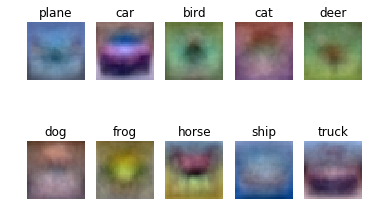

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])